Importación de librerías y configuración

In [1]:
import os

# tengo un problema en el entorno local que no me deja aplicar el clustering, con estos parametros se arreglan en google colab es posible que no hagan falta
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# el resto de librerías normales a usar en el ejercicio
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

# librerias usadas para el segundo modelo solamente y mejoras
import spacy
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import v_measure_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# funcion para calcular bcubed usando precision recall y f1
def b_cubed_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    n = np.sum(cm)
    row_sums = np.sum(cm, axis=1)
    col_sums = np.sum(cm, axis=0) 
    
    precision = np.sum((cm ** 2) / col_sums[None, :]) / n
    recall = np.sum((cm ** 2) / row_sums[:, None]) / n
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

In [3]:
# recursos necesarios de nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()
stop_words_en = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Carga y Preprocesamiento

In [ ]:
# IMPORTANTE: para que la celda se ejecute correctamente el notebook tiene que estar dentro de la carpeta corpus-clustering
def quitar_cabecera(texto):
    # elimina las cabeceras del documento buscando el primer doble salto
    partes = re.split(r"\n\s*\n", texto, maxsplit=1)
    return partes[1] if len(partes) > 1 else partes[0]

def preprocesar_texto(texto):
    # quitamos la cabecera
    cuerpo = quitar_cabecera(texto)
    
    # dejamos solo las letras en minusculas y numeros
    texto_limpio = re.sub(r'[^a-zA-Z0-9\s]', ' ', cuerpo).lower()
    
    # tokenizacion y lematizacion
    tokens = nltk.word_tokenize(texto_limpio)
    tokens_lematizados = [
        lemmatizer.lemmatize(w) for w in tokens 
        # filtramos las stopwords y palabras muy cortas
        if w not in stop_words_en and len(w) > 2 
    ]
    return " ".join(tokens_lematizados)

def cargar_datos():
    datos = []
    categorias = [d for d in os.listdir(".") if os.path.isdir(d) and not d.startswith('.')]
    
    for cat in categorias:
        ruta = os.path.join(".", cat)
        for archivo in os.listdir(ruta):
            with open(os.path.join(ruta, archivo), "r", encoding="latin-1") as f:
                contenido = f.read()
                datos.append({
                    "texto": preprocesar_texto(contenido),
                    "etiqueta_real": cat
                })
    return pd.DataFrame(datos)

df = cargar_datos()

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_true = le.fit_transform(df['etiqueta_real'])

# reducción de dimensionalidad con LSA
lsa_pipeline = make_pipeline(TruncatedSVD(n_components=100, random_state=42), Normalizer(copy=False))

# Configuraciones tras varías iterraciones con los mejores valores posibles
vectores = {
    'TF-IDF': TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.5,
        stop_words='english'
    ),
    'Count': CountVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.5,
        stop_words='english'
    )
}

modelos = {
    'KMeans': KMeans(
        n_clusters=7, 
        random_state=42, 
        n_init=30,
        max_iter=500
    ),
    'Jerarquico': AgglomerativeClustering(n_clusters=7)
}

In [6]:
for nombre_vector, vector in vectores.items():
    X_sparse = vector.fit_transform(df['texto'])
    X_lsa = lsa_pipeline.fit_transform(X_sparse)
    
    print(f"Resultados {nombre_vector}")
    
    for nombre_modelo, modelo in modelos.items():
        y_pred = modelo.fit_predict(X_lsa)
        # metricas
        v_score = v_measure_score(y_true, y_pred)
        ari = adjusted_rand_score(y_true, y_pred)
        bc_p, bc_r, bc_f1 = b_cubed_score(y_true, y_pred)
        
        print(f"\nModelo: {nombre_modelo}")
        print(f"  V-Measure: {v_score:.4f}")
        print(f"  ARI:       {ari:.4f}")
        print(f"  BCubed F1: {bc_f1:.4f} (P: {bc_p:.2f}, R: {bc_r:.2f})")

Resultados TF-IDF

Modelo: KMeans
  V-Measure: 0.4497
  ARI:       0.3190
  BCubed F1: 0.4758 (P: 0.46, R: 0.50)


c:\Users\alexh\miniconda3\envs\pydata-book\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Modelo: Jerarquico
  V-Measure: 0.4147
  ARI:       0.1794
  BCubed F1: 0.5072 (P: 0.39, R: 0.71)
Resultados Count

Modelo: KMeans
  V-Measure: 0.2494
  ARI:       0.1682
  BCubed F1: 0.3303 (P: 0.32, R: 0.34)

Modelo: Jerarquico
  V-Measure: 0.2932
  ARI:       0.1868
  BCubed F1: 0.3931 (P: 0.33, R: 0.49)


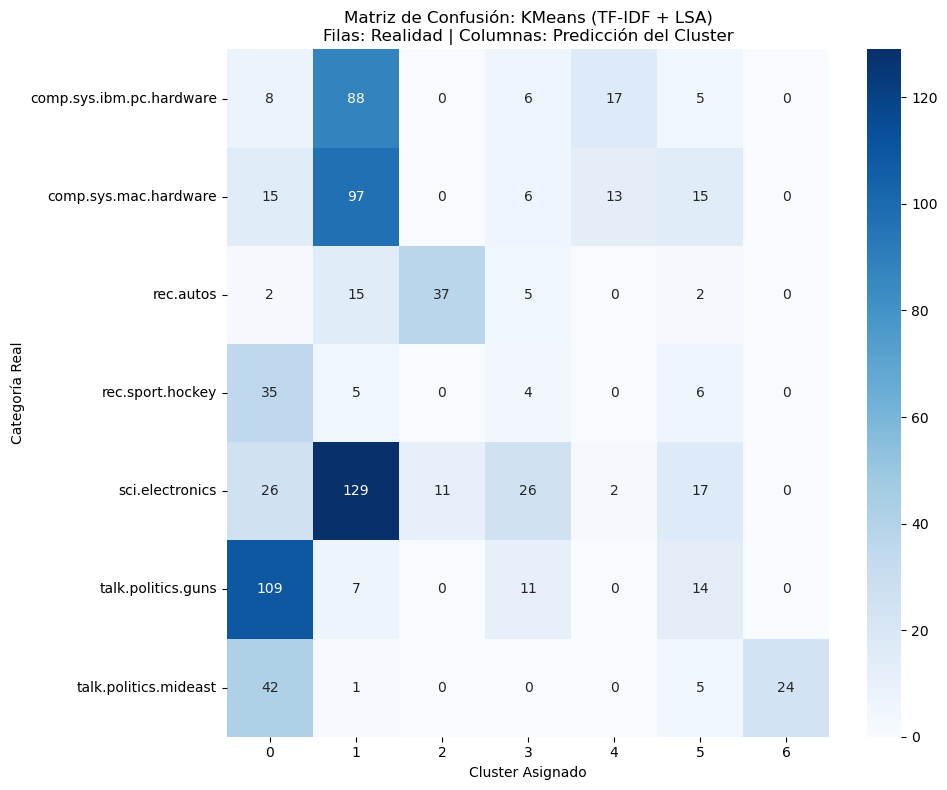

In [7]:
cm = confusion_matrix(y_true, y_pred)
nombres_clases = le.classes_
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(7),
            yticklabels=nombres_clases)

plt.title('Matriz de Confusión: KMeans (TF-IDF + LSA)\nFilas: Realidad | Columnas: Predicción del Cluster')
plt.xlabel('Cluster Asignado')
plt.ylabel('Categoría Real')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# segunda parte, uso de spacy para el preprocesado
!python -m spacy download en_core_web_lg

     ---------------------------------------- 0.0/400.7 MB ? eta -:--:--
     --------------------------------------- 3.7/400.7 MB 19.7 MB/s eta 0:00:21
      ------------------------------------- 10.5/400.7 MB 32.8 MB/s eta 0:00:12
     -- ----------------------------------- 21.2/400.7 MB 35.2 MB/s eta 0:00:11
     --- ---------------------------------- 36.4/400.7 MB 45.3 MB/s eta 0:00:09
     ---- --------------------------------- 46.7/400.7 MB 46.4 MB/s eta 0:00:08
     ----- -------------------------------- 62.9/400.7 MB 52.2 MB/s eta 0:00:07
     ------- ------------------------------ 74.7/400.7 MB 52.8 MB/s eta 0:00:07
     -------- ----------------------------- 90.7/400.7 MB 56.1 MB/s eta 0:00:06
     --------- --------------------------- 104.9/400.7 MB 58.8 MB/s eta 0:00:06
     ----------- ------------------------- 120.1/400.7 MB 58.9 MB/s eta 0:00:05
     ------------ ------------------------ 136.3/400.7 MB 61.1 MB/s eta 0:00:05
     ------------ ------------------------ 138.

In [8]:
# carga de modelo spacy
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("Error al cargar el modelo")

In [10]:
def preprocesar_texto_spacy(texto):
    # mismo preprocesamiento de cabeceras y caracteres
    partes = re.split(r"\n\s*\n", texto, maxsplit=1)
    cuerpo = partes[1] if len(partes) > 1 else partes[0]
    texto_limpio = re.sub(r'[^a-zA-Z0-9\s]', ' ', cuerpo).lower()
    
    # orocesamiento con Spacy
    nlp.max_length = 2000000 
    doc = nlp(texto_limpio)
    
    # filtrado final
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 2]
    return " ".join(tokens)

def cargar_datos_spacy(directorio_raiz="."):
    datos = []
    categorias = [d for d in os.listdir(".") if os.path.isdir(d) and not d.startswith('.')]
    for cat in categorias:
        ruta_cat = os.path.join(directorio_raiz, cat)
        archivos = os.listdir(ruta_cat)
        
        for archivo in archivos:
            ruta_archivo = os.path.join(ruta_cat, archivo)
            with open(ruta_archivo, "r", encoding="latin-1") as f:
                contenido = f.read()
                datos.append({
                    "texto_spacy": preprocesar_texto_spacy(contenido), 
                    "etiqueta_real": cat
                })
                
    return pd.DataFrame(datos)

df_spacy = cargar_datos_spacy()
le = LabelEncoder()
y_true_spacy = le.fit_transform(df_spacy['etiqueta_real'])

In [16]:
# aplicamos tf-idf, luego svd normalizamos y aplicamos kmeans
pipeline_optimo = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(random_state=42)),
    ('norm', Normalizer(copy=False)),
    ('kmeans', KMeans(n_clusters=7, random_state=42))
])

# hiperparametros a probar
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000, 10000],       
    'tfidf__ngram_range': [(1, 1), (1, 2)],     
    'svd__n_components': [10, 30, 50, 70],  
    'kmeans__n_init': [30, 50],  
}

grid = GridSearchCV(pipeline_optimo, param_grid, cv=5, scoring=make_scorer(v_measure_score), n_jobs=-1)
grid.fit(df_spacy['texto_spacy'], y_true_spacy)

print(f"Mejores parámetros: {grid.best_params_}")

Mejores parámetros: {'kmeans__n_init': 50, 'svd__n_components': 30, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 1)}


  V-Measure: 0.5375
  ARI:       0.3828
  BCubed F1: 0.5555 (P: 0.52, R: 0.60)


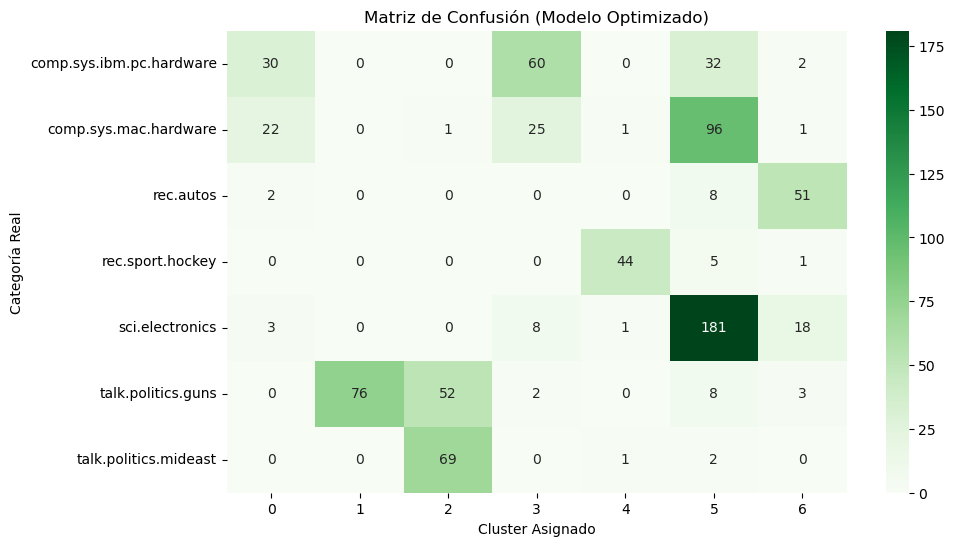

In [12]:
# mejor modelo
modelo_final = grid.best_estimator_
# predecimos sobre todo el conjunto
y_pred_opt = modelo_final.predict(df_spacy['texto_spacy'])

# metricas para obtener resultados
v_score_opt = v_measure_score(y_true_spacy, y_pred_opt)
ari_opt = adjusted_rand_score(y_true_spacy, y_pred_opt)
bc_p_opt, bc_r_opt, bc_f1_opt = b_cubed_score(y_true_spacy, y_pred_opt)

print(f"  V-Measure: {v_score_opt:.4f}")
print(f"  ARI:       {ari_opt:.4f}")
print(f"  BCubed F1: {bc_f1_opt:.4f} (P: {bc_p_opt:.2f}, R: {bc_r_opt:.2f})")

# matriz de confusion
cm_opt = confusion_matrix(y_true_spacy, y_pred_opt)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', 
            yticklabels=le.classes_)
plt.title('Matriz de Confusión (Modelo Optimizado)')
plt.xlabel('Cluster Asignado')
plt.ylabel('Categoría Real')
plt.show()

In [ ]:
# parte opcional
vectorizador_opt = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.5,
    stop_words='english',
    ngram_range=(1, 2)
)
lsa_opt = make_pipeline(TruncatedSVD(n_components=100, random_state=42), Normalizer(copy=False))
X_sparse_opt = vectorizador_opt.fit_transform(df['texto'])
X_lsa_opt = lsa_opt.fit_transform(X_sparse_opt)

In [ ]:
inercias = []
rango_k = range(2, 20)

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_lsa_opt)
    inercias.append(kmeans.inertia_)

# grafico del codo
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, 'bo-', markersize=8)
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Suma de errores al cuadrado)')
plt.title('Método del Codo: Detección de k óptimo')
plt.grid(True)
plt.xticks(rango_k)
plt.show()

In [ ]:
K_NUEVO= 14
modelo_optimo = KMeans(n_clusters=K_NUEVO, random_state=42, n_init=30, max_iter=500)
y_pred_optimo = modelo_optimo.fit_predict(X_lsa_opt)
cm_opt = confusion_matrix(y_true, y_pred_optimo)

plt.figure(figsize=(10, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', 
            yticklabels=le.classes_)
plt.title(f'Matriz de Confusión (k={K_NUEVO})')
plt.xlabel(f'Cluster Asignado (0 a {K_NUEVO-1})')
plt.ylabel('Categoría Real')
plt.show()

# metricas externas para evaluacion
ari_opt = adjusted_rand_score(y_true, y_pred_optimo)
nmi_opt = normalized_mutual_info_score(y_true, y_pred_optimo)
f1_opt = f1_score(y_true, y_pred_optimo, average='macro', zero_division=0)

print(f"F1: {f1_opt:.4f} ARI: {ari_opt:.4f} NMI: {nmi_opt:.4f}")